In [78]:
%matplotlib inline

import time
import logging
import random
import numpy as np
from scipy import signal
from pylab import rcParams # figureを大きくする用
import mpl_toolkits.axes_grid1 # カラーバーの大きさを調整する用
import datetime
import math

import pyqtgraph as pg
from pyqtgraph.Qt import QtGui, QtCore
import matplotlib.pyplot as plt

import brainflow
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds, BrainFlowError
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations, WindowFunctions, DetrendOperations

In [79]:
rcParams['figure.figsize'] = 10,10

BoardShim.enable_dev_board_logger()
params = BrainFlowInputParams()
params.serial_port = '/dev/cu.usbserial-DM03GV5S' # ここにCOMポート名

board_id = 0
board = BoardShim(board_id, params)
board.prepare_session()
board.start_stream()

# key = input('Enterを押したら計測終了')

[2023-07-01 16:20:43.982] [board_logger] [info] incoming json: {
    "file": "",
    "ip_address": "",
    "ip_port": 0,
    "ip_protocol": 0,
    "mac_address": "",
    "other_info": "",
    "serial_number": "",
    "serial_port": "/dev/cu.usbserial-DM03GV5S",
    "timeout": 0
}
[2023-07-01 16:20:43.982] [board_logger] [trace] Board object created 0
[2023-07-01 16:20:43.982] [board_logger] [info] openning port /dev/cu.usbserial-DM03GV5S
[2023-07-01 16:20:43.989] [board_logger] [trace] port /dev/cu.usbserial-DM03GV5S is open
[2023-07-01 16:20:43.993] [board_logger] [trace] set port settings
[2023-07-01 16:20:43.993] [board_logger] [debug] sending v to the board
[2023-07-01 16:20:45.018] [board_logger] [debug] sending d to the board
[2023-07-01 16:20:46.114] [board_logger] [debug] use stub streamer
[2023-07-01 16:20:46.114] [board_logger] [debug] sending b to the board


In [80]:
## 計測終了
originaldata = board.get_board_data()
# datenow = datetime.datetime.now()
# strnow = "SimpleRecData/" + str(datenow.year)+'-'+str(datenow.month)+'-'+str(datenow.day)+'-'+str(datenow.hour)+'-'+str(datenow.minute)+'-'+str(datenow.second)
# np.savetxt(strnow+'.csv',originaldata,delimiter=',')

logging.info('End')
if board.is_prepared():
    logging.info('Releasing session')
    board.release_session()
    print('Board Relearsed')

print('Analyzing data...')

Board Relearsed
Analyzing data...


[2023-07-01 16:21:52.459] [board_logger] [debug] sending s to the board


In [81]:
## 解析
channels_use = BoardShim.get_exg_channels(board_id)
exg_channels = channels_use[0:len(channels_use)-1]
fs = BoardShim.get_sampling_rate(board_id)

# Detrendとフィルタリング
# 最初と最後の5秒は除外
data = originaldata # 一応元データを取っておく
dlen = data.shape[1]
data = data[:,3*fs:dlen-3*fs]
fftall = np.zeros((len(exg_channels),int(fs/2)+1)) # 最後の+1不要？
for count, channel in enumerate(exg_channels):
    # plot timeseries
    DataFilter.detrend(data[channel], DetrendOperations.CONSTANT.value)
    DataFilter.perform_bandpass(data[channel], fs, 51.0, 100.0, 2,
                                FilterTypes.BUTTERWORTH.value, 0)
    DataFilter.perform_bandpass(data[channel], fs, 51.0, 100.0, 2,
                                FilterTypes.BUTTERWORTH.value, 0)
    DataFilter.perform_bandstop(data[channel], fs, 50.0, 4.0, 2,
                                FilterTypes.BUTTERWORTH.value, 0)
    fftnow = signal.welch(data[channel],fs,nperseg=fs)
    fftall[count,:] = fftnow[1]


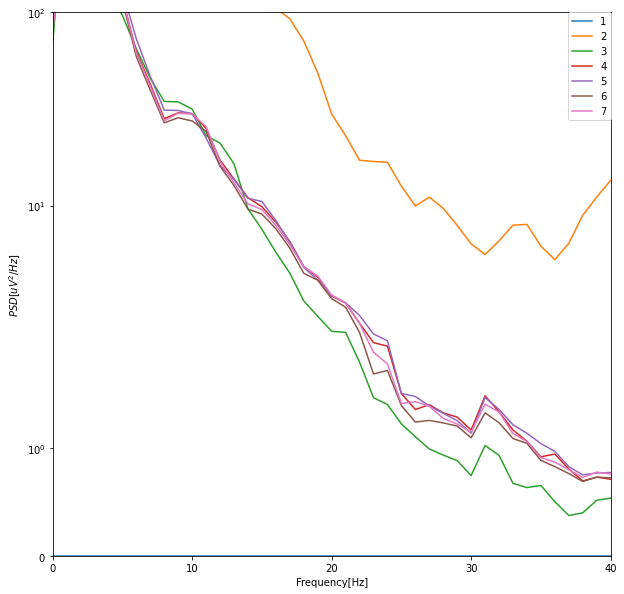

In [82]:
# まずは一括で・各チャンネルを一本の線で、一つのグラフに表示
figfft = plt.figure(facecolor='w')
axfft = figfft.add_subplot(111) # 軸を追加する
# axfft.set_yscale('log')
axfft.set_yscale("symlog")
plt.xlim(0,40)
plt.ylim(0,100)
# axfft.set_ylim(-10,500)
for count, channel in enumerate(exg_channels):
    axfft.plot(fftall[channel-1],label=str(channel))
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=10)
axfft.set_xlabel('Frequency[Hz]')
axfft.set_ylabel("$PSD[uV^2/Hz]$")
plt.rcParams["font.size"] = 30

In [83]:
## 振幅が一定を超えた場合その前後を解析から除外
# welch法を自分で実装する感覚？
# 1秒窓をオーバーラップ0で繰り返す。
# 振幅が閾値（とりあえず100）を超えたらそこは解析から除外

datalength = data.shape[1] # dps
lwindow = fs
nwindow = int(np.floor(datalength/fs)) # 窓数
ncount = np.zeros(7)
fftall_clean = np.zeros((len(exg_channels),int(fs/2)+1))

for stp in range(int(np.floor(0*nwindow/5)),int(np.floor(5*nwindow/5))): # range(nwindow):
    datanow = data[:,stp*lwindow:(stp+1)*lwindow]
    for count, channel in enumerate(exg_channels):
        if np.amax(datanow[channel]) < 100: # 閾値を100としてみる
            fftnow = signal.welch(datanow[channel],fs,nperseg=fs)
            fftall_clean[count,:] += fftnow[1] # 0はラベル
            ncount[count] = ncount[count]+1

for count, channel in enumerate(exg_channels):
    fftall_clean[count,:] = fftall_clean[count,:] / ncount[count]

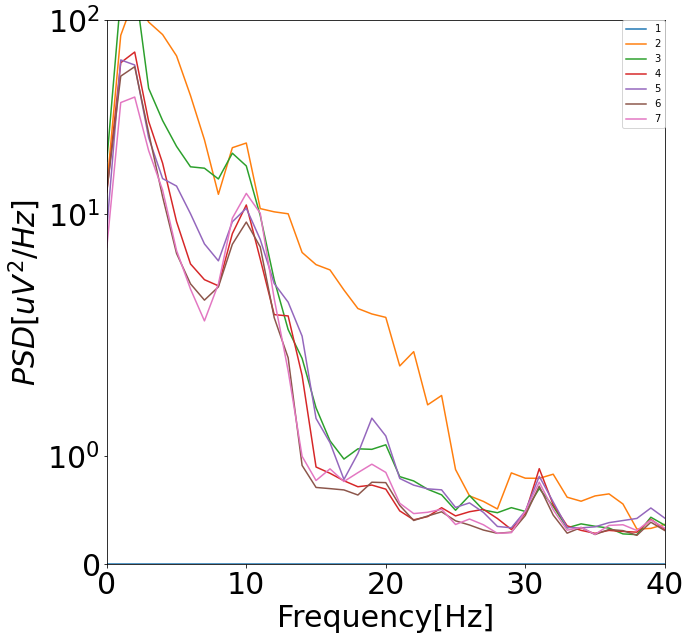

In [84]:
figfft_clean = plt.figure(facecolor='w')
axfft_clean = figfft_clean.add_subplot(111) # 軸を追加する
axfft_clean.set_yscale("symlog")
plt.xlim(0,40) # 40
plt.ylim(0,100) #100
# axfft_clean.set_ylim(-10,500)
for count, channel in enumerate(exg_channels):
    axfft_clean.plot(fftall_clean[channel-1],label=str(channel))
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=10)
axfft_clean.set_xlabel('Frequency[Hz]')
axfft_clean.set_ylabel("$PSD[uV^2/Hz]$")
plt.rcParams["font.size"] = 30

In [85]:
# 1chの時間周波数

mainch = 6 # 解析するチャンネル
datalength = data.shape[1] # dps
duration = datalength / fs # 秒に換算
lwindow = 2*fs # 窓長
lstep = 25 # スライドの長さ（25dps）
nwindow = int(np.floor((datalength-lwindow)/25)) # 25dps(100ms)が何個あるか
tfmbox = np.zeros((int((fs/2)+1),nwindow))

for stp in range(nwindow):
    datanow = data[mainch,stp*lstep:stp*lstep+lwindow-1]
    fftnow = signal.welch(datanow,fs,nperseg=fs)
    tfmbox[:,stp] = fftnow[1]
    

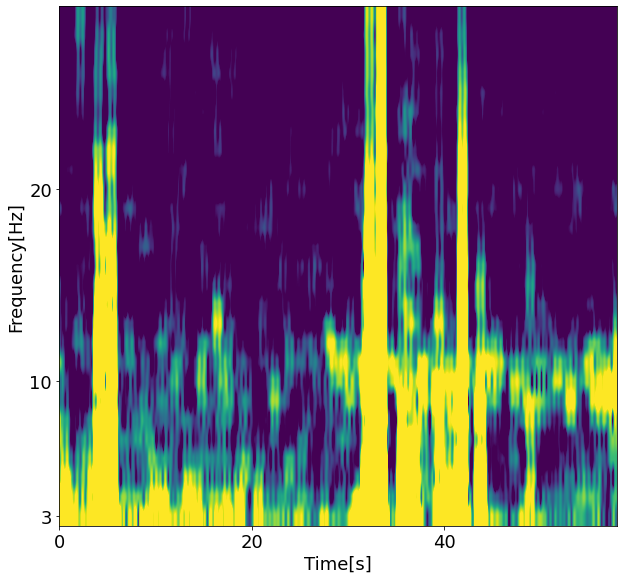

In [86]:
rcParams['figure.figsize'] = 10,10

minf = 3
maxf = 30
#maxf = 50

logtfmbox = np.log10(tfmbox)
figtfm = plt.figure(facecolor="w")
axtfm = figtfm.add_subplot(111)
im = axtfm.imshow(logtfmbox[minf:maxf,:],vmin=-0, vmax=1.2,aspect=20) # vmaxは1.2だった
axtfm.set_yticks([0,7,17]) # 最後の項は追加した
axtfm.set_yticklabels([minf,10,20],fontsize=18) # 最後の項は追加した
axtfm.set_ylabel('Frequency[Hz]',fontsize=18)
axtfm.set_xlabel('Time[s]',fontsize=18)

tstep = lstep/fs # 1マスにつき0.1s
xtks = np.arange(0,nwindow,20*fs/lstep)
xtkls = xtks/10
xtkls = xtkls.astype(int)
axtfm.set_xticks(xtks)
axtfm.set_xticklabels(xtkls,fontsize=18)
#divider = mpl_toolkits.axes_grid1.make_axes_locatable(axtfm)

#cax = divider.append_axes('right', '5%', pad='3%')
#figtfm.colorbar(im,cax=cax)
axtfm.invert_yaxis()


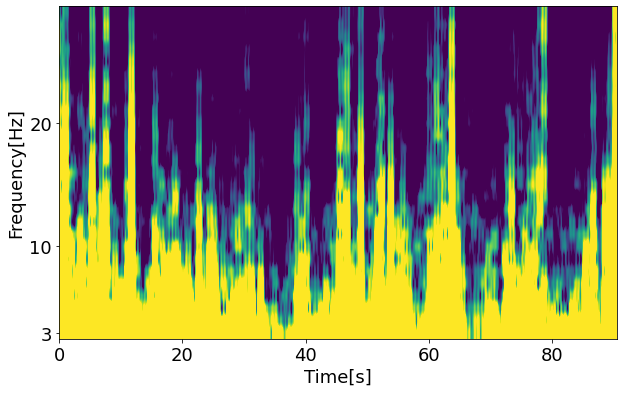

In [43]:
rcParams['figure.figsize'] = 10,10

minf = 3
maxf = 30
#maxf = 50

logtfmbox = np.log10(tfmbox)
figtfm = plt.figure(facecolor="w")
axtfm = figtfm.add_subplot(111)
im = axtfm.imshow(logtfmbox[minf:maxf,:],vmin=-0, vmax=1.2,aspect=20) # vmaxは1.2だった
axtfm.set_yticks([0,7,17]) # 最後の項は追加した
axtfm.set_yticklabels([minf,10,20],fontsize=18) # 最後の項は追加した
axtfm.set_ylabel('Frequency[Hz]',fontsize=18)
axtfm.set_xlabel('Time[s]',fontsize=18)

tstep = lstep/fs # 1マスにつき0.1s
xtks = np.arange(0,nwindow,20*fs/lstep)
xtkls = xtks/10
xtkls = xtkls.astype(int)
axtfm.set_xticks(xtks)
axtfm.set_xticklabels(xtkls,fontsize=18)
#divider = mpl_toolkits.axes_grid1.make_axes_locatable(axtfm)

#cax = divider.append_axes('right', '5%', pad='3%')
#figtfm.colorbar(im,cax=cax)
axtfm.invert_yaxis()


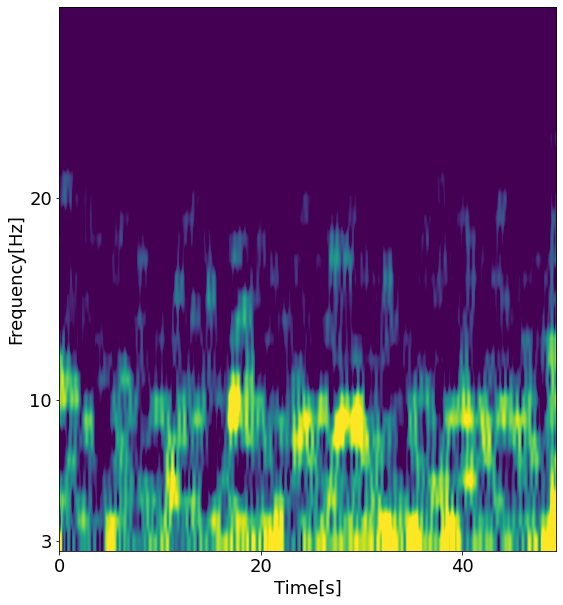

In [ ]:
rcParams['figure.figsize'] = 10,10

minf = 3
maxf = 30
#maxf = 50

logtfmbox = np.log10(tfmbox)
figtfm = plt.figure(facecolor="w")
axtfm = figtfm.add_subplot(111)
im = axtfm.imshow(logtfmbox[minf:maxf,:],vmin=-0, vmax=1.2,aspect=20) # vmaxは1.2だった
axtfm.set_yticks([0,7,17]) # 最後の項は追加した
axtfm.set_yticklabels([minf,10,20],fontsize=18) # 最後の項は追加した
axtfm.set_ylabel('Frequency[Hz]',fontsize=18)
axtfm.set_xlabel('Time[s]',fontsize=18)

tstep = lstep/fs # 1マスにつき0.1s
xtks = np.arange(0,nwindow,20*fs/lstep)
xtkls = xtks/10
xtkls = xtkls.astype(int)
axtfm.set_xticks(xtks)
axtfm.set_xticklabels(xtkls,fontsize=18)
#divider = mpl_toolkits.axes_grid1.make_axes_locatable(axtfm)

#cax = divider.append_axes('right', '5%', pad='3%')
#figtfm.colorbar(im,cax=cax)
axtfm.invert_yaxis()


# 

In [19]:
datenow = datetime.datetime.now()
strnow = "SimpleRecData/" + str(datenow.year)+'-'+str(datenow.month)+'-'+str(datenow.day)+'-'+str(datenow.hour)+'-'+str(datenow.minute)+'-'+str(datenow.second)
data2save = originaldata[1:8,:]
np.savetxt(strnow+'.csv',data2save,delimiter=',')

In [23]:
board.release_session()
print('Board Relearsed')

BrainFlowError: BOARD_NOT_CREATED_ERROR:15 unable to release streaming session